<a href="https://colab.research.google.com/github/rpizarrog/innovacion-empresarial/blob/main/notebook_python/Caso_022_Exponencial_vs_Polinomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: Rubén Pizarro Gurrola
Fecha: Febrero 2025**

# Objetivo

Evaluar la eficiencia de un modelo de regresión exponencial contra un modelo de regresión polinomial usando el estadístico RMSE

# Descripción

* Cargar datos
* Describir datos y estructura de los datos
* Visualizar dispersión de todos los datos
* Particionar datos 80% datos de entrenamiento y 20% datos de validación con semilla de 2025.
* Construir el modelo exponencial con la transformación logartítmica adecuada
* Visualizar curva de tendencia con los datos de entrenamiento y con los datos de validación
* Determinar los coeficientes conforme a la fórmula $Y = β_0 \cdot e ^{β_1\cdot x_i}$ con transformaci[on logarítmica adecuada.
* Describir valores de los coeficientes
* Hacer una predicción específica tal vez $4.35$
* Hacer predicciones con datos de validación
* Evaluar predicciones y determinar *r quare* y *RMSE*.



# Desarrollo

La relación entre el tiempo y el número de bacterias sigue un crecimiento exponencial, modelado como $Y=𝑎𝑒^{𝑏𝑥}$.

## Cargar datos

* La variable tiempo mide en horas y es el lapso transcurrido en el proceso de acumulación de baterías de un experimento

* La variable Baterías Acumuladas,representa la cantidad acumulada de baterías en una línea de producción o proceso de almacenamiento. Se expresa en unidades de baterías.


## Cargar librerías


In [40]:
import pandas as pd
import numpy as np
from sklearn import linear_model

from collections import Counter as Counter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures # Polinomial
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
#%matplotlib inline

## Crear funciones



In [43]:
# Esta función regresa los datos en formato csv cargados en memoria RAM
def f_cargar_datos(ruta):
  # Cargar datos de la carpeta sample_data
  # datos = pd.read_csv('sample_data/estaturas_pesos.csv')

  # cargar datos de github.com enlace en la nube internet
  datos = pd.read_csv(ruta)
  return datos

# Función que devuelve las medias aritméticas y desviaciones estándar de dos variables numéricas de una muestra
def f_medias (independiente, dependiente):
  medias = [np.mean(independiente), np.mean(dependiente)]
  return medias

# Función que construye diagrama de dispersión
def f_dispersion (x, y, x_nombre, y_nombre):
  medias = f_medias(x, y)

  cova, r, r_square = f_cov_corr(x, y)   # Crear el diagrama de dispersión
  plt.scatter(x, y, s = 5)

  # Etiquetas y título
  plt.xlabel(x_nombre)
  plt.ylabel(y_nombre)
  plt.title(print('Diagrama de Dispersión. Corr Pearson'))

  plt.axvline(x=medias[0], color='blue', linestyle='--', linewidth=0.5,
            label="Media "+ x_nombre + ":" + str(np.round(medias[0], 2)))
  plt.axhline(y=medias[1], color='green', linestyle='--', linewidth=0.5,
            label="Media "+ y_nombre+":" + str(np.round(medias[1], 2)))
  plt.legend()

  # Subtítulo debajo del gráfico
  plt.figtext(0.5, -0.05, f'R Pearson: {np.round(r, 4)}', ha='center', fontsize=10)

  # Mostrar el diagrama de dispersión
  plt.show()

# Función que devuelve la covariana y correlación de Pearson y r square de dos variables numéricas de una muestra
def f_cov_corr(independiente, dependiente):
  covar = np.cov(independiente, dependiente, ddof=1)[0,1]
  r = np.corrcoef(independiente, dependiente)[0,1]
  r_square = r ** 2
  return covar, r, r_square

# Función que devuelve estad´siticos de una variable numérica
def f_media_moda_mediana_n(datos):
  # Calcular la media aritmética
  media = np.mean(datos)

  # Calcular la moda
  contador = Counter(datos)
  moda = contador.most_common(1)[0][0]

  # Calcular la mediana
  mediana = np.median(datos)

  # ¿Cuántos nnpúmeros son?
  n = len(datos)
  return media, moda, mediana, n

# función que visualiza histograma de una variable numérica en estructira tipo lista
# Re Utiliza la función f_media_moda_mediana_n
def f_histograma(datos, contexto):
  min = np.min(datos)
  max = np.max(datos)

# Convertir a entero
  min = int(min)
  max = int(max)

  # Calcular el número óptimo de clases usando la regla de Sturges
  n = len(datos)
  k = int(round(1 + math.log2(n)))

  plt.hist(datos, bins=range(min, max, k), edgecolor="black")
  plt.xlabel(contexto)

  media, moda, mediana, N = f_media_moda_mediana_n(datos)

  # Agregar líneas punteadas roja, azul y verde para representar media, mediana y moda
  medias = f_media_moda_mediana_n(datos)
  plt.axvline(x=media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
  plt.axvline(x=mediana, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.2f}')
  plt.axvline(x=moda, color='yellow', linestyle='--', linewidth=2, label=f'Moda: {moda:.2f}')

  plt.ylabel("Frecuencia")
  plt.title("Distribución de los datos: "+contexto)

  plt.legend()
  plt.grid(False)
  plt.show()

def f_modelo_polinomial(v_independiente, v_dependiente, grado):
    """
    Ajusta un modelo de regresión polinomial.

    Parámetros:
    - v_independiente: array-like, variable independiente (X)
    - v_dependiente: array-like, variable dependiente (y)
    - grado: int, grado del polinomio

    Retorna:
    - modelo_polinomial: modelo de regresión ajustado
    - poly: objeto PolynomialFeatures para transformar nuevas entradas
    """
    # Transformar la variable independiente en características polinomiales
    poly = PolynomialFeatures(degree=grado)
    ind_train_poly = poly.fit_transform(v_independiente.reshape(-1, 1))

    # Construcción y entrenamiento del modelo de regresión lineal
    modelo_polinomial = LinearRegression()
    modelo_polinomial.fit(ind_train_poly, v_dependiente)  # Solo la Y original

    return modelo_polinomial, poly  # Devuelve también 'poly' para transformar futuras entradas


# Función que visualiza la dispersión de los datos y la curva de tendencia

def f_regresion_curva_tendencia(modelo, poly, x, y, xlabel, ylabel):
    """
    Grafica la curva de regresión polinomial y los datos originales.

    Parámetros:
    - modelo: modelo de regresión polinomial entrenado.
    - poly: objeto PolynomialFeatures utilizado para transformar los datos.
    - x: array-like, valores de la variable independiente.
    - y: array-like, valores de la variable dependiente.
    - xlabel: str, etiqueta del eje X.
    - ylabel: str, etiqueta del eje Y.
    """

    # Obtener el término de intercepción y coeficientes
    intercepto = modelo.intercept_
    coeficientes = modelo.coef_
    print(f"Intercepto (β0): {intercepto}")
    print(f"Coeficientes (β1, β2, ...): {coeficientes}")

    # Crear un rango de valores de X para visualizar la curva
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

    # Transformar los valores de X_range con el mismo objeto `poly`
    x_range_poly = poly.transform(x_range)

    # Predecir los valores de y para X_range
    predicciones = modelo.predict(x_range_poly)

    # Graficar los datos reales
    plt.scatter(x, y, color='blue', s=30, label='Datos originales')

    # Graficar la curva de regresión polinomial
    plt.plot(x_range, predicciones, color='red', label='Curva de tendencia')

    # Configurar etiquetas y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Regresión Polinomial')
    plt.legend()
    plt.grid()

    # Mostrar el gráfico
    plt.show()

# Función para graficar la curva de tendencia de una exponencial
def f_curva_exponencial(datos_entrenamiento, datos_validacion, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    plt.scatter(datos_entrenamiento[independiente], datos_entrenamiento[dependiente], label="Datos de entrenamiento", color="blue", alpha=0.5)
    plt.scatter(datos_validacion[independiente], datos_validacion[dependiente], label="Datos de validación", color="red", alpha=0.5)
    x_range = np.linspace(min(v_independiente), max(v_independiente), 100)
    y_curve = a * np.exp(b * x_range)
    plt.plot(x_range, y_curve, label="Curva de tendencia exponencial", color="green")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("Curva de Tendencia Exponencial")
    plt.legend()
    plt.show()




## Cargar datos


In [4]:
# https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/baterias_acumuladas_exponencial.csv
ruta = "https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/baterias_acumuladas_exponencial.csv"
datos = f_cargar_datos(ruta)

print(datos)

      Tiempo  Baterias_Acumuladas
0    0.00000            12.483571
1    0.10101             9.720992
2    0.20202            14.080071
3    0.30303            18.903793
4    0.40404            10.583323
..       ...                  ...
95   9.59596           457.185850
96   9.69697           485.136148
97   9.79798           504.902612
98   9.89899           524.386921
99  10.00000           544.808565

[100 rows x 2 columns]


## Estructura de los datos

In [5]:
datos.info()
datos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tiempo               100 non-null    float64
 1   Baterias_Acumuladas  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


,Tiempo,Baterias_Acumuladas
count,100.000000,100.000000
mean,5.000000,134.934142
std,2.930454,142.529279
min,0.000000,7.342457
25%,2.500000,27.161010
50%,5.000000,74.329454
75%,7.500000,201.875856
max,10.000000,544.808565


## Histogramas


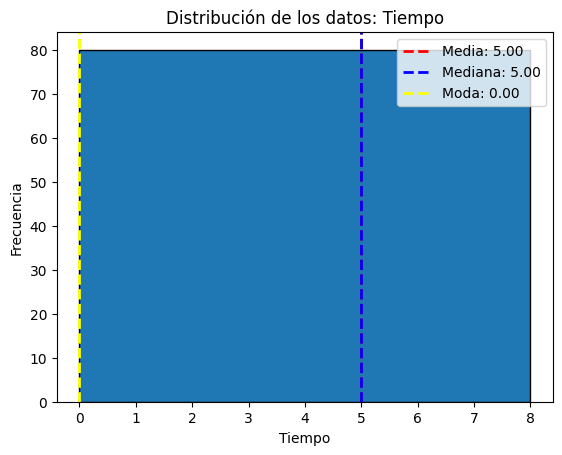

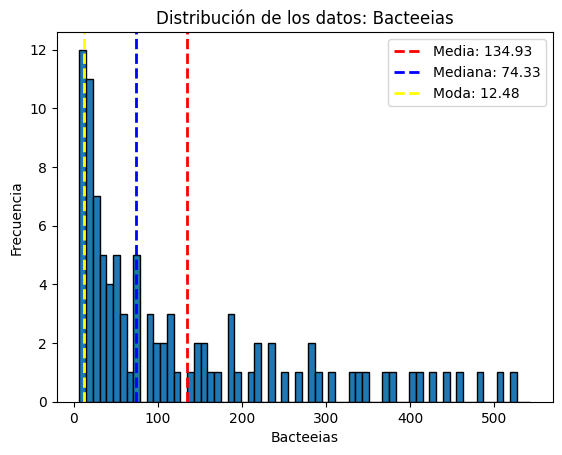

In [6]:
# estaturas pesos
independiente = 'Tiempo'
dependiente = 'Baterias_Acumuladas'

f_histograma(datos[independiente], "Tiempo")

f_histograma(datos[dependiente], "Bacteeias")

Tanto la variable tiempo como la acumulación de bacterias no tienen un comportamiento normal por lo que se presumen otro tipo de comportamiento, es decir tal vez exponencial.


## Dispersión de los datos

Diagrama de Dispersión. Corr Pearson


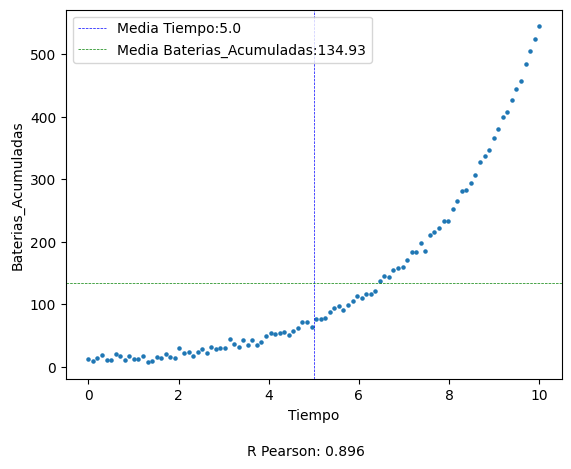

In [7]:


f_dispersion(datos[independiente], datos[dependiente], independiente, dependiente)

Se observa una tendencia exponencial, es decir a mayor tiempo mayor acumulación de bacterias y esta aumenta exponencialmente.

## Particionar datos

* 80% datos de entrenamiento y
* 20% datos de validación
* con semilla de 2025


In [31]:
# Convertir a numpy arrays
v_independiente = datos[independiente].to_numpy()
v_dependiente = datos[dependiente].to_numpy()

print("Independiente")
print("\n")
print (v_independiente)
print()
print("Dependiente")
print(v_dependiente)

# División de los datos en entrenamiento (80%) y validación (20%)
ind_train, ind_test, dep_train, dep_test = train_test_split(
    v_independiente, v_dependiente, test_size=0.20, random_state=2025
)

# Crear DataFrame con datos de entrenamiento
datos_entrenamiento = pd.DataFrame({independiente: ind_train.flatten(), dependiente: dep_train})

# Crear DataFrame con datos de validación (corregido)
datos_validacion = pd.DataFrame({independiente: ind_test.flatten(), dependiente: dep_test})

# Mostrar los primeros valores de cada conjunto
print("\nDatos de entrenamiento:")
print(datos_entrenamiento)
print ("Los datos de entrenamiento son ", datos_entrenamiento.shape)

print("\nDatos de validación:")
print(datos_validacion)


print ("Los datos de validación son ", datos_validacion.shape)



Independiente


[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.0808080

## Transformación

De acuerdo a chat GPT 2025, cuando se quiere ajustar un modelo de regresión exponencial, nexiste una situación a resolver: la relación entre la variable **independiente** y la **dependiente** no es lineal. Esto significa que no se puede aplicar directamente un modelo de regresión lineal. Para resolver esto, se usa una transformación logarítmica.

$$
Y=a\cdot e^{b\cdot x}
$$

* $Y$ es la variable dependiente (lo que se quiere predecir).
* $𝑥$ es la variable independiente.
* $𝑎$ y $b$ son coeficientes que determinan la forma de la curva.
* $𝑒$ es la base del logaritmo natural ($≈2.718$).

El modelo exponencial no es lineal en sus parámetros, lo que significa que no se puede usar directamente una regresión lineal estándar para estimar coeficientes $a$ y $b$.

Al aplicar logaritmo natural a ambos lados de la ecuación y de acuerdo a las propiedades de los logaritmos, se tiene lo siguiente

$$
ln(Y) = ln(a\cdot e^{b\cdot x})
$$
Aplicando propiedad logaritmo de un producto
$$
ln(Y) = ln(a) + ln(e^{b\cdot x})
$$

y dado que el logaritmo natural es la función inversa de la exponencial, aplicando la propiedad de logaritmo de una potenciase se puede simplificar: $ln(e
^{bx})=bx$ entonces:
$$
Y=a\cdot e^{b\cdot x} \rightarrow ln(Y) = ln(a) + bx
$$


## Construyendo el modelo



In [32]:
# Aplicar transformación logarítmica a la variable dependiente
dep_train_log = np.log(dep_train)
dep_test_log = np.log(dep_test)

# Ajuste del modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(ind_train.reshape(-1, 1), dep_train_log)

LinearRegression()

## Valores de los coeficientes a y b



In [37]:
ln_a = modelo.intercept_
a = np.exp(ln_a)
b = modelo.coef_[0]

print("Coeficiente a:", a)
print("Coeficiente b:", b)


Coeficiente a: 9.15826568794571
Coeficiente b: 0.4112296400914294


## Curva de predicción o curva de tendencia

Se hace la curva de predicción o tendencia con los datos de entrenamiento y con los datos de validación mandando llamar la función previamente preparada *f_curva_exponencial(datos_entrenamiento, datos_validacion, independiente, dependiente)*.

Se observa cual sería la predicción estimada para cualquier valor de la variable independiente $x=Tiempo$.


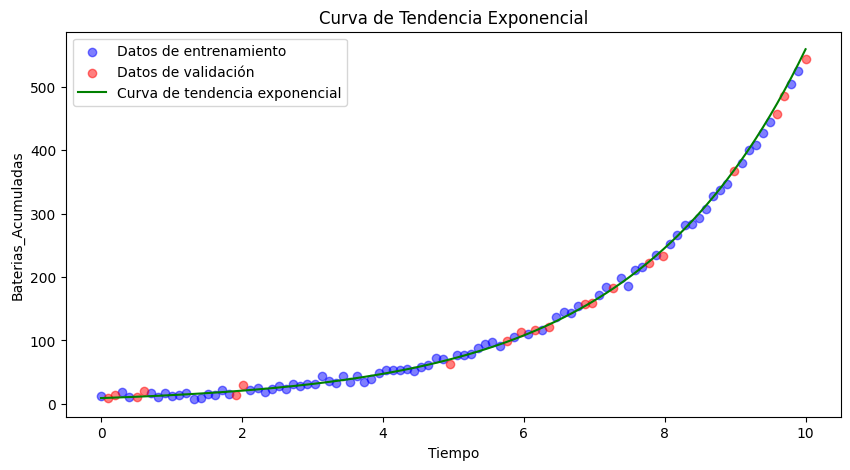

In [47]:

# Llamar a la función de visualización
f_curva_exponencial(datos_entrenamiento, datos_validacion, independiente, dependiente)


Significa que una predicción para un valor de $x$ tal vez igual a $4.35$ la predicción sería:

$$
Y=a\cdot e^{b\cdot x}
$$

$$
Y=9.15826568794571 * 2.7182^{0.4112*4.35} = 54.7899
$$


In [38]:
x = 4.35 # Valor de x en unidades de tiempo
e = np.e # e = 2.7182
print(a * e ** (b * x))

# Predicción para un valor específico de x
x = np.array([[4.35]])  # Convertir en formato adecuado para predicción
dep_pred_log_x = modelo.predict(x)
dep_pred_x = np.exp(dep_pred_log_x)  # Deshacer la transformación logarítmica
print(f"Predicción para x=4.35: {dep_pred_x[0]:.4f}")


54.78989393927099
Predicción para x=4.35: 54.7899


## Prediccionesa con datos de validación



In [53]:
# Predicciones en el conjunto de validación
predicciones_log = modelo.predict(ind_test.reshape(-1, 1))
predicciones = np.exp(predicciones_log)  # Deshacer la transformación logarítmica
print (predicciones)
diccionario = {'Tiempo': ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)



[ 70.10792582 224.32807069 115.41057895 160.90317745  11.75039563
 473.8068913  154.35643705  20.16372963   9.95160177  11.27230196
 493.90252695 369.28538694  97.74310233 125.40803698 182.2570119
 559.44947862 106.21011265   9.54669645 243.76052212  21.01893662]
       Tiempo        Real    Predicho
0    4.949495   63.597599   70.107926
1    7.777778  222.964668  224.328071
2    6.161616  116.664946  115.410579
3    6.969697  159.239610  160.903177
4    0.606061   20.639411   11.750396
5    9.595960  457.185850  473.806891
6    6.868687  157.839981  154.356437
7    1.919192   14.486026   20.163730
8    0.202020   14.080071    9.951602
9    0.505051   11.068043   11.272302
10   9.696970  485.136148  493.902527
11   8.989899  367.072948  369.285387
12   5.757576   98.498469   97.743102
13   6.363636  121.509185  125.408037
14   7.272727  183.222051  182.257012
15  10.000000  544.808565  559.449479
16   5.959596  113.342285  106.210113
17   0.101010    9.720992    9.546696
18   7.979798 

## Evalaución del modelo con *r square* y RMSE



In [58]:
# Evaluación del modelo en la escala original
r2 = r2_score(dep_test, predicciones)
rmse = np.sqrt(mean_squared_error(dep_test, predicciones))

print ("r square", r2)
print ("RMSE:", rmse)

r square 0.9981059347228814
RMSE: 7.115362986117149


# Interpretación

La variable *Tiempo* explica aproximadamente un 99% a la acumulación de la variable *Bacterias*.

El valor de RMSE es de 7.11 significa la eficiencia del modelo y debe ser comparado contra otros modelos; significa que las predicciones pueden equivocarse en 7.11 unidades hacie arriba o hacia abajo con respecto a kla predicción real.


# Bibliografía

ChatGPT, 2025 modelo de regresión exponencial

ChatGPT, 2025. Propiedades de los logaritmos. Transformación de una ecuación lineal.

Larson, R., & Edwards, B. (2016). Cálculo con aplicaciones (10ª ed.). Cengage Learning.

Stewart, J. (2015). Cálculo: Trascendentes tempranas (7ª ed.). Cengage Learning.

Zill, D. G. (2013). Matemáticas avanzadas para ingeniería (5ª ed.). McGraw-Hill.